### Baby-sitting the Learning Process

#### Defining the Fully Connected Layer

In [1]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None

    def forward(self, X):
        self.X = X
        output = np.dot(self.X, self.W) + self.b
        return output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Defining the Rectified Linear Activation Layer


In [2]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### Defining the softmax function

In [3]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Defining the Cross Entropy Loss

In [4]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

### Loading the dataset : Lets us load the training and the test data and check the size of the tensors. Lets us also display the first few images from the training set.

In [5]:
from keras.datasets import mnist
from keras.utils import np_utils


(train_features, train_targets), (test_features, test_targets) = mnist.load_data()

train_features = train_features.reshape(60000, 784)
print train_features.shape
test_features = test_features.reshape(10000, 784)
print test_features.shape


# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

print train_targets.shape
print test_targets.shape

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets

/usr/local/anaconda/python2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(60000, 784)
(10000, 784)
(60000,)
(10000,)


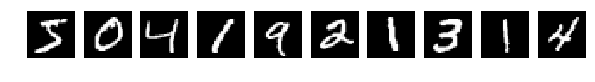

label for each of the above image: [5 0 4 1 9 2 1 3 1 4]


In [6]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

### Here, we define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [7]:
class NN():
    def __init__(self, lossfunc=CrossEntropy(), mode='train'):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)  + ((Lambda / (2 * y.shape[0])) * np.sum([np.sum(w**2) for w in self.params[0][0]]))
        nextgrad = self.loss_func.backward(out,y) + ((Lambda/y.shape[0]) * np.sum([np.sum(w) for w in self.params[0][0]]))
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

#### Defining the update function (SGD)

In [8]:
def update(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = (mu * v[i]) - (learning_rate * g[i])
            p[i] += v[i]

#### Defining a function which gives us the minibatches (both the datapoint and the corresponding label)

In [9]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]

        minibatches.append((X_batch, y_batch))
    return minibatches

#### The traning loop

In [10]:
def sgd(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None, Lambda=0, verb=True):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)
    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = []
        y_val_pred = []
        y_train1 = []
        y_vall = []
        for ii in range(0, m_train, minibatch_size):
            X_tr = X_train[ii:ii + minibatch_size, : ]
            y_tr = y_train[ii:ii + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for ii in range(0, m_val, minibatch_size):
            X_va = X_val[ii:ii + minibatch_size, : ]
            y_va = y_val[ii:ii + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)
        
        ## weights
        w = np.array(net.params[0][0])
        
        ## adding regularization to cost
        mean_train_loss = (sum(loss_batch) / float(len(loss_batch)))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        if verb:
            if i%50==0:
                print("Epoch {3}/{4}: Loss = {0} | Training Accuracy = {1}".format(mean_train_loss, train_acc, val_acc, i, epoch))
    return net, val_acc

#### Checking the accuracy of the model 

In [11]:
def check_accuracy(y_true, y_pred):
    count = 0
    for i,j in zip(y_true, y_pred):
        if int(i)==j:
            count +=1
    return float(count)/float(len(y_true))

#### Invoking all that we have created until now

In [12]:
from random import shuffle


## input size
input_dim = X_train.shape[1]

def train_and_test_loop(iterations, lr, Lambda, verb=True):
    ## hyperparameters
    iterations = iterations
    learning_rate = lr
    hidden_nodes = 10
    output_nodes = 10

    ## define neural net
    nn = NN()
    nn.add_layer(Linear(input_dim, hidden_nodes))

    nn, val_acc = sgd(nn, X_train , y_train, minibatch_size=1000, epoch=iterations, learning_rate=learning_rate,\
                      X_val=X_val, y_val=y_val, Lambda=Lambda, verb=verb)
    return val_acc

### Double Check that the loss is reasonable : Disable the regularization

In [ ]:
lr = 0.00001
Lambda = 0
train_and_test_loop(1, lr, Lambda)

Is the loss range correct?? What about accuracy, does it make sense for an untrained network?

### Now, lets crank up the Lambda(Regularization)and check what it does to our loss function.

In [142]:
lr = 0.00001
Lambda = 1e3
train_and_test_loop(1, lr, Lambda)

Epoch 0/1: Loss = 4.56518470809e+101 | Training Accuracy = 0.0987166666667


0.098

loss went up. Good! (Another sanity check)

### Now, lets overfit to a small subset of our dataset, in this case 20 images.

In [113]:
X_train_subset = X_train[0:20]

In [114]:
y_train_subset = y_train[0:20]

In [115]:
X_train = X_train_subset
y_train = y_train_subset

In [116]:
X_train.shape

(20, 784)

In [117]:
y_train.shape

(20,)

### Tip: Make sure that you can overfit very small portion of the training data
So, set a small learning rate and turn regularization off

In the code below:
- Take the first 20 examples from MNIST
- turn off regularization(reg=0.0)
- use simple vanilla 'sgd'

In [118]:
lr = 0.0001
Lambda = 0
train_and_test_loop(10000, lr, Lambda)

Epoch 0/10000: Loss = 2.29299230471 | Training Accuracy = 0.1
Epoch 50/10000: Loss = 2.27716278532 | Training Accuracy = 0.2
Epoch 100/10000: Loss = 2.26150682497 | Training Accuracy = 0.2
Epoch 150/10000: Loss = 2.24602279271 | Training Accuracy = 0.25
Epoch 200/10000: Loss = 2.23070900465 | Training Accuracy = 0.25
Epoch 250/10000: Loss = 2.21556372339 | Training Accuracy = 0.4
Epoch 300/10000: Loss = 2.20058515778 | Training Accuracy = 0.55
Epoch 350/10000: Loss = 2.18577146342 | Training Accuracy = 0.5
Epoch 400/10000: Loss = 2.17112074356 | Training Accuracy = 0.55
Epoch 450/10000: Loss = 2.15663105054 | Training Accuracy = 0.55
Epoch 500/10000: Loss = 2.14230038772 | Training Accuracy = 0.6
Epoch 550/10000: Loss = 2.12812671186 | Training Accuracy = 0.65
Epoch 600/10000: Loss = 2.11410793591 | Training Accuracy = 0.6
Epoch 650/10000: Loss = 2.10024193214 | Training Accuracy = 0.65
Epoch 700/10000: Loss = 2.08652653568 | Training Accuracy = 0.65
Epoch 750/10000: Loss = 2.072959548

Epoch 6300/10000: Loss = 1.11037926809 | Training Accuracy = 0.95
Epoch 6350/10000: Loss = 1.10477075265 | Training Accuracy = 0.95
Epoch 6400/10000: Loss = 1.09920038463 | Training Accuracy = 0.95
Epoch 6450/10000: Loss = 1.09366788744 | Training Accuracy = 0.95
Epoch 6500/10000: Loss = 1.08817298647 | Training Accuracy = 0.95
Epoch 6550/10000: Loss = 1.08271540898 | Training Accuracy = 0.95
Epoch 6600/10000: Loss = 1.07729488413 | Training Accuracy = 0.95
Epoch 6650/10000: Loss = 1.07191114294 | Training Accuracy = 0.95
Epoch 6700/10000: Loss = 1.06656391822 | Training Accuracy = 0.95
Epoch 6750/10000: Loss = 1.06125294464 | Training Accuracy = 0.95
Epoch 6800/10000: Loss = 1.05597795861 | Training Accuracy = 0.95
Epoch 6850/10000: Loss = 1.05073869831 | Training Accuracy = 0.95
Epoch 6900/10000: Loss = 1.04553490369 | Training Accuracy = 0.95
Epoch 6950/10000: Loss = 1.04036631639 | Training Accuracy = 0.95
Epoch 7000/10000: Loss = 1.03523267978 | Training Accuracy = 0.95
Epoch 7050

0.4718

Very small loss,  train accuracy 100, nice! We are successful in overfitting. 

### Loading the original dataset again

In [119]:
import pandas as pd
from keras.datasets import mnist
from keras.utils import np_utils


(train_features, train_targets), (test_features, test_targets) = mnist.load_data()

train_features = train_features.reshape(60000, 784)
print train_features.shape
test_features = test_features.reshape(10000, 784)
print test_features.shape


# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

print train_targets.shape
print test_targets.shape

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets

(60000, 784)
(10000, 784)
(60000,)
(10000,)


### Start with small regularization and find learning rate that makes the loss go down.

- we start with Lambda(small regularization) = 1e-7
- we start with a small learning rate = 1e-7

In [120]:
lr = 1e-7
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 2.3009780135 | Training Accuracy = 0.133566666667
Epoch 50/500: Loss = 2.30064390573 | Training Accuracy = 0.13435
Epoch 100/500: Loss = 2.30030992169 | Training Accuracy = 0.134933333333
Epoch 150/500: Loss = 2.29997606121 | Training Accuracy = 0.135783333333
Epoch 200/500: Loss = 2.29964232411 | Training Accuracy = 0.1367
Epoch 250/500: Loss = 2.29930871022 | Training Accuracy = 0.137316666667
Epoch 300/500: Loss = 2.29897521936 | Training Accuracy = 0.138033333333
Epoch 350/500: Loss = 2.29864185136 | Training Accuracy = 0.138766666667
Epoch 400/500: Loss = 2.29830860604 | Training Accuracy = 0.139466666667
Epoch 450/500: Loss = 2.29797548323 | Training Accuracy = 0.140166666667


0.138

Loss barely changing. Learning rate is probably too low.

### Okay now lets try a (larger) learning rate 1e6. What could possibly go wrong?

- Learning rate lr = 1e6
- Regularization lambda = 1e-7


In [121]:
lr = 1e6
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 4.57097312616e+220 | Training Accuracy = 0.0987166666667


/usr/local/anaconda/python2/lib/python2.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in square
/usr/local/anaconda/python2/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Epoch 50/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 100/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 150/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 200/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 250/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 300/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 350/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 400/500: Loss = nan | Training Accuracy = 0.0987166666667
Epoch 450/500: Loss = nan | Training Accuracy = 0.0987166666667


0.098

Loss exploding. Learning rate is too high. 
Cost is very high. Always means high learning rate

### Lets try to train now with a value of learning rate between 1e-7 and 1e6

- learning rate = 1e4
- regularization remains the small, lambda = 1e-7

In [144]:
lr = 1e4
Lambda = 1e-7
train_and_test_loop(500, lr, Lambda)

Epoch 0/500: Loss = 8.85131574014 | Training Accuracy = 0.899633333333
Epoch 50/500: Loss = 6.84291364561 | Training Accuracy = 0.898283333333
Epoch 100/500: Loss = 8.08382855856 | Training Accuracy = 0.898416666667
Epoch 150/500: Loss = 9.63714543264 | Training Accuracy = 0.892716666667
Epoch 200/500: Loss = 10.7163696015 | Training Accuracy = 0.9062
Epoch 250/500: Loss = 11.7163368671 | Training Accuracy = 0.901616666667
Epoch 300/500: Loss = 12.914686422 | Training Accuracy = 0.898016666667
Epoch 350/500: Loss = 13.9447751067 | Training Accuracy = 0.88805
Epoch 400/500: Loss = 15.3446817515 | Training Accuracy = 0.904366666667
Epoch 450/500: Loss = 16.115403978 | Training Accuracy = 0.897116666667


0.8754

Still too high learning rate. Loss is not decreasing. The rough range of learning rate we should be cross validating is somewhere between [1e4 to 1e-7]

### Hyperparameter Optimization

### Cross validation Strategy


- Do coarse -> fine cross-validation in stages

- First stage: only a few epochs to get rough idea of what params work
- Second stage: longer running time, finer search
- … (repeat as necessary)

### Tip for detecting explosions in the solver: 
- If the cost is ever > 3 * original cost, break out early




### For example: Run coarse search for 100 iterations


In [146]:
import math
for k in range(1,100):
    lr = math.pow(10, np.random.uniform(-7.0, 4.0))
    Lambda = math.pow(10, np.random.uniform(-5,5))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Try 1/100: Best_val_acc: 0.8398, lr: 7.45468488425e-05, Lambda: 0.000159903616103

Try 2/100: Best_val_acc: 0.5706, lr: 3.56991738793e-06, Lambda: 20.1237892817

Try 3/100: Best_val_acc: 0.9223, lr: 0.00992739351399, Lambda: 0.0021095154455

Try 4/100: Best_val_acc: 0.1022, lr: 1.78885786607e-07, Lambda: 0.00309312931524

Try 5/100: Best_val_acc: 0.8975, lr: 0.00076891785533, Lambda: 0.448688796025

Try 6/100: Best_val_acc: 0.9063, lr: 0.00133006129195, Lambda: 2.70937081705



/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in square


Try 7/100: Best_val_acc: 0.098, lr: 4.32965252147, Lambda: 18924.5154169

Try 8/100: Best_val_acc: 0.9026, lr: 0.00107923301317, Lambda: 2.13502220135

Try 9/100: Best_val_acc: 0.098, lr: 0.00192349535701, Lambda: 4637.1944929



### Now run finer search

In [147]:
import math
for k in range(1,10):
    lr = math.pow(10, np.random.uniform(-3.0, -2.0))
    Lambda = math.pow(10, np.random.uniform(-5,2))
    best_acc = train_and_test_loop(100, lr, Lambda, False)
    print("Try {0}/{1}: Best_val_acc: {2}, lr: {3}, Lambda: {4}\n".format(k, 100, best_acc, lr, Lambda))

Try 1/100: Best_val_acc: 0.9218, lr: 0.0115688318738, Lambda: 0.105897187144



/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in square
/usr/local/anaconda/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  


Try 2/100: Best_val_acc: 0.098, lr: 0.0531240091238, Lambda: 91.7611762264

Try 3/100: Best_val_acc: 0.8841, lr: 0.000370529160594, Lambda: 0.0311068816491

Try 4/100: Best_val_acc: 0.769, lr: 1.82585492168e-05, Lambda: 0.685726311211

Try 5/100: Best_val_acc: 0.9232, lr: 0.0266641552965, Lambda: 0.00610437364682

Try 6/100: Best_val_acc: 0.9163, lr: 0.00314008487927, Lambda: 0.841207757356

Try 7/100: Best_val_acc: 0.098, lr: 0.00594118250727, Lambda: 51.894609946

Try 8/100: Best_val_acc: 0.9182, lr: 0.0052358650493, Lambda: 0.000602817654684

Try 9/100: Best_val_acc: 0.9232, lr: 0.0183392121727, Lambda: 0.0191855165621

